# 01 - Exploratory Data Analysis

**BuzzwordLearner: Predicting Career Domain and Seniority from LinkedIn Profiles**

This notebook explores the LinkedIn CV dataset to understand:
1. Dataset structure and size
2. Label distributions (department/domain and seniority)
3. Text characteristics (length, language, patterns)
4. Career history patterns
5. Data quality issues

## Setup

In [1]:
import sys
sys.path.insert(0, '..')

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from pathlib import Path

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Data directory
DATA_DIR = Path('../data')

print("Setup complete!")

Setup complete!


## 1. Load the Data

In [2]:
# Load annotated LinkedIn CVs
with open(DATA_DIR / 'linkedin-cvs-annotated.json', 'r', encoding='utf-8') as f:
    cvs_annotated = json.load(f)

# Load non-annotated LinkedIn CVs
with open(DATA_DIR / 'linkedin-cvs-not-annotated.json', 'r', encoding='utf-8') as f:
    cvs_not_annotated = json.load(f)

# Load label dictionaries
department_labels = pd.read_csv(DATA_DIR / 'department-v2.csv')
seniority_labels = pd.read_csv(DATA_DIR / 'seniority-v2.csv')

print(f"Annotated CVs: {len(cvs_annotated)}")
print(f"Non-annotated CVs: {len(cvs_not_annotated)}")
print(f"Department label examples: {len(department_labels)}")
print(f"Seniority label examples: {len(seniority_labels)}")

Annotated CVs: 609
Non-annotated CVs: 390
Department label examples: 10145
Seniority label examples: 9428


## 2. Understanding the Data Structure

Each CV is a list of positions. Let's examine the structure:

In [3]:
# Look at the first CV
print("First CV (person with multiple positions):")
print(json.dumps(cvs_annotated[0], indent=2))

First CV (person with multiple positions):
[
  {
    "organization": "Depot4Design GmbH",
    "linkedin": "https://www.linkedin.com/company/depot4design-gmbh",
    "position": "Prokurist",
    "startDate": "2019-08",
    "endDate": null,
    "status": "ACTIVE",
    "department": "Other",
    "seniority": "Management"
  },
  {
    "organization": "Depot4Design GmbH",
    "linkedin": "https://www.linkedin.com/company/depot4design-gmbh",
    "position": "CFO",
    "startDate": "2019-07",
    "endDate": null,
    "status": "ACTIVE",
    "department": "Other",
    "seniority": "Management"
  },
  {
    "organization": "Depot4Design GmbH",
    "linkedin": "https://www.linkedin.com/company/depot4design-gmbh",
    "position": "Betriebswirtin",
    "startDate": "2019-07",
    "endDate": null,
    "status": "ACTIVE",
    "department": "Other",
    "seniority": "Professional"
  },
  {
    "organization": "Depot4Design GmbH",
    "linkedin": "https://www.linkedin.com/company/depot4design-gmbh",
  

In [4]:
# Look at another example
print("\nSecond CV (person with career history):")
print(json.dumps(cvs_annotated[1], indent=2))


Second CV (person with career history):
[
  {
    "organization": "Computer Solutions",
    "linkedin": "https://www.linkedin.com/company/computer-solutions",
    "position": "Solutions Architect",
    "startDate": "2024-03",
    "endDate": null,
    "status": "ACTIVE",
    "department": "Information Technology",
    "seniority": "Professional"
  },
  {
    "organization": "Computer Solutions",
    "linkedin": "https://www.linkedin.com/company/computer-solutions",
    "position": "Senior Network Engineer",
    "startDate": "2019-07",
    "endDate": "2024-03",
    "status": "INACTIVE",
    "department": "Information Technology",
    "seniority": "Senior"
  },
  {
    "organization": "Texas A&M University-Corpus Christi",
    "linkedin": "",
    "position": "Manager of Network Services",
    "startDate": "2017-02",
    "endDate": "2019-07",
    "status": "INACTIVE",
    "department": "Information Technology",
    "seniority": "Professional"
  },
  {
    "organization": "Texas A&M Univer

In [5]:
# Extract all fields from positions
sample_position = cvs_annotated[0][0]
print("Position fields:")
for key, value in sample_position.items():
    print(f"  - {key}: {type(value).__name__} (example: {repr(value)[:50]}...)")

Position fields:
  - organization: str (example: 'Depot4Design GmbH'...)
  - linkedin: str (example: 'https://www.linkedin.com/company/depot4design-gmb...)
  - position: str (example: 'Prokurist'...)
  - startDate: str (example: '2019-08'...)
  - endDate: NoneType (example: None...)
  - status: str (example: 'ACTIVE'...)
  - department: str (example: 'Other'...)
  - seniority: str (example: 'Management'...)


### Key Observations:
- Each CV is a **list of positions** (current and past jobs)
- Position fields: `organization`, `linkedin`, `position`, `startDate`, `endDate`, `status`, `department`, `seniority`
- **status**: `ACTIVE` (current job), `INACTIVE` (past job), `UNKNOWN`
- **Target variables**: `department` and `seniority` (only in annotated data)
- **Input for prediction**: The `position` field (job title)

## 3. Flatten Data for Analysis

In [6]:
def flatten_cvs(cvs, cv_id_start=0):
    """Flatten list of CVs into a DataFrame of positions."""
    records = []
    for cv_id, cv in enumerate(cvs, start=cv_id_start):
        for pos_idx, position in enumerate(cv):
            record = {
                'cv_id': cv_id,
                'position_idx': pos_idx,
                **position
            }
            records.append(record)
    return pd.DataFrame(records)

# Flatten annotated data
df_annotated = flatten_cvs(cvs_annotated)
print(f"Total positions in annotated data: {len(df_annotated)}")
print(f"Total CVs (unique cv_id): {df_annotated['cv_id'].nunique()}")
df_annotated.head(10)

Total positions in annotated data: 2638
Total CVs (unique cv_id): 609


,cv_id,position_idx,organization,linkedin,position,startDate,endDate,status,department,seniority
0,0,0,Depot4Design GmbH,https://www.linkedin.com/company/depot4design-...,Prokurist,2019-08,None,ACTIVE,Other,Management
1,0,1,Depot4Design GmbH,https://www.linkedin.com/company/depot4design-...,CFO,2019-07,None,ACTIVE,Other,Management
2,0,2,Depot4Design GmbH,https://www.linkedin.com/company/depot4design-...,Betriebswirtin,2019-07,None,ACTIVE,Other,Professional
3,0,3,Depot4Design GmbH,https://www.linkedin.com/company/depot4design-...,Prokuristin,2019-07,None,ACTIVE,Other,Management
4,0,4,Depot4Design GmbH,https://www.linkedin.com/company/depot4design-...,CFO,2019-07,None,ACTIVE,Other,Management
5,0,5,Nagel Car Group,,Buchhalterin,2000-05,2019-06,INACTIVE,Other,Professional
6,1,0,Computer Solutions,https://www.linkedin.com/company/computer-solu...,Solutions Architect,2024-03,None,ACTIVE,Information Technology,Professional
7,1,1,Computer Solutions,https://www.linkedin.com/company/computer-solu...,Senior Network Engineer,2019-07,2024-03,INACTIVE,Information Technology,Senior
8,1,2,Texas A&M University-Corpus Christi,,Manager of Network Services,2017-02,2019-07,INACTIVE,Information Technology,Professional
9,1,3,Texas A&M University-Corpus Christi,,Infrastructure Administrator II,2015-06,2017-02,INACTIVE,Information Technology,Professional


In [7]:
# Basic info
df_annotated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2638 entries, 0 to 2637
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   cv_id         2638 non-null   int64 
 1   position_idx  2638 non-null   int64 
 2   organization  2638 non-null   object
 3   linkedin      2638 non-null   object
 4   position      2638 non-null   object
 5   startDate     2520 non-null   object
 6   endDate       1897 non-null   object
 7   status        2638 non-null   object
 8   department    2638 non-null   object
 9   seniority     2638 non-null   object
dtypes: int64(2), object(8)
memory usage: 206.2+ KB


## 4. Filter to ACTIVE Positions (Our Target)

According to the project description, we need to predict characteristics of the **current job** (status = ACTIVE).

In [8]:
# Status distribution
print("Position Status Distribution:")
print(df_annotated['status'].value_counts())
print(f"\nPercentage ACTIVE: {(df_annotated['status'] == 'ACTIVE').mean():.1%}")

Position Status Distribution:
status
INACTIVE    1897
ACTIVE       623
UNKNOWN      118
Name: count, dtype: int64

Percentage ACTIVE: 23.6%


In [9]:
# Filter to active positions only
df_active = df_annotated[df_annotated['status'] == 'ACTIVE'].copy()
print(f"Active positions: {len(df_active)}")
print(f"Unique CVs with active positions: {df_active['cv_id'].nunique()}")

Active positions: 623
Unique CVs with active positions: 478


In [10]:
# Some people have multiple active positions!
active_per_cv = df_active.groupby('cv_id').size()
print("Active positions per CV:")
print(active_per_cv.value_counts().sort_index())

Active positions per CV:
1     380
2      78
3      10
4       3
5       4
7       1
8       1
10      1
Name: count, dtype: int64


## 5. Department (Domain) Analysis

In [11]:
# Department distribution in active positions
dept_counts = df_active['department'].value_counts()
print(f"Unique departments: {len(dept_counts)}")
print("\nDepartment Distribution:")
print(dept_counts)

Unique departments: 11

Department Distribution:
department
Other                     344
Information Technology     62
Sales                      46
Consulting                 39
Project Management         39
Marketing                  22
Business Development       20
Human Resources            16
Purchasing                 15
Administrative             14
Customer Support            6
Name: count, dtype: int64


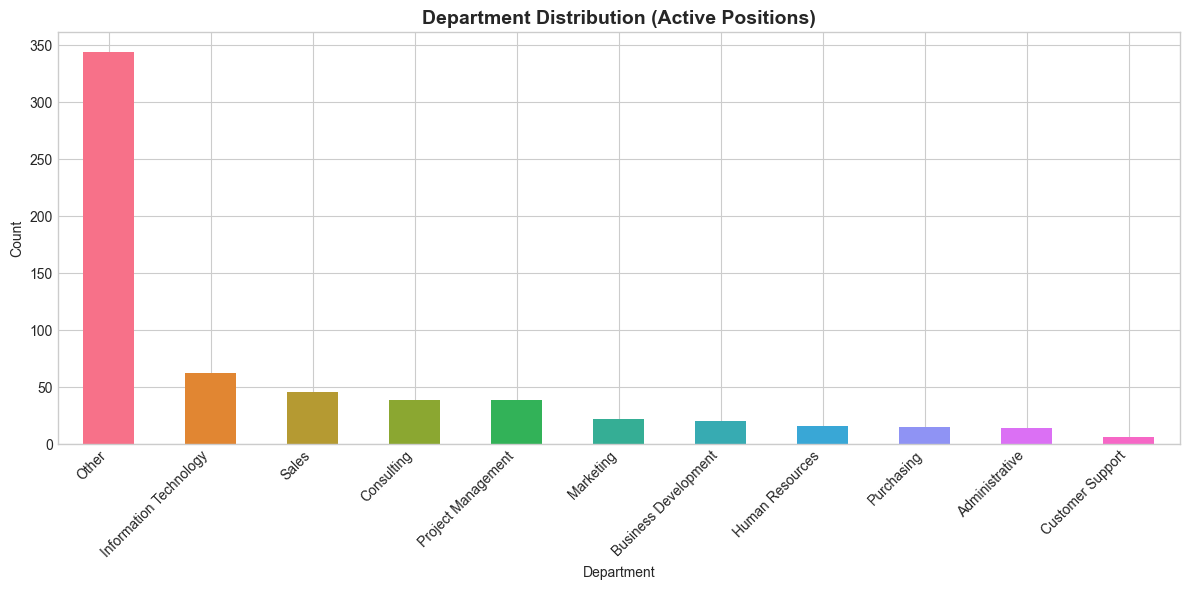

In [12]:
# Visualize department distribution
fig, ax = plt.subplots(figsize=(12, 6))
dept_counts.plot(kind='bar', ax=ax, color=sns.color_palette('husl', len(dept_counts)))
ax.set_title('Department Distribution (Active Positions)', fontsize=14, fontweight='bold')
ax.set_xlabel('Department')
ax.set_ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../reports/figures/department_distribution.png', dpi=150)
plt.show()

In [13]:
# Department proportions
dept_props = (dept_counts / dept_counts.sum() * 100).round(1)
print("Department Proportions (%):")
for dept, prop in dept_props.items():
    print(f"  {dept}: {prop}%")

Department Proportions (%):
  Other: 55.2%
  Information Technology: 10.0%
  Sales: 7.4%
  Consulting: 6.3%
  Project Management: 6.3%
  Marketing: 3.5%
  Business Development: 3.2%
  Human Resources: 2.6%
  Purchasing: 2.4%
  Administrative: 2.2%
  Customer Support: 1.0%


### Department Observations:
- **"Other"** is the most common category - this is a catch-all for unclassified positions
- **Class imbalance** is significant - some departments have very few samples
- Main departments: Sales, Information Technology, Marketing, Project Management, Consulting, Business Development

## 6. Seniority Analysis

In [14]:
# Seniority distribution
seniority_counts = df_active['seniority'].value_counts()
print(f"Unique seniority levels: {len(seniority_counts)}")
print("\nSeniority Distribution:")
print(seniority_counts)

Unique seniority levels: 6

Seniority Distribution:
seniority
Professional    216
Management      192
Lead            125
Senior           44
Director         34
Junior           12
Name: count, dtype: int64


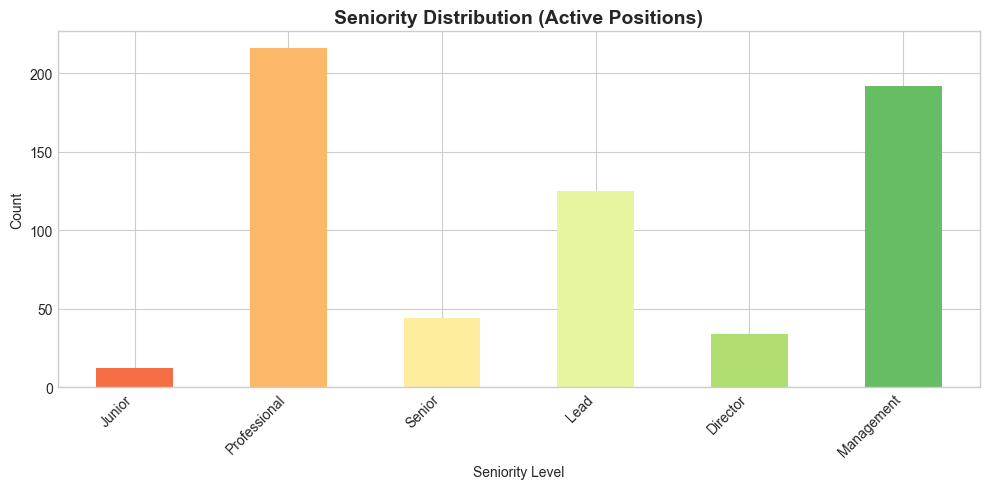

In [15]:
# Visualize seniority distribution
fig, ax = plt.subplots(figsize=(10, 5))

# Order seniority levels logically
seniority_order = ['Junior', 'Professional', 'Senior', 'Lead', 'Director', 'Management']
seniority_ordered = seniority_counts.reindex([s for s in seniority_order if s in seniority_counts.index])

colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(seniority_ordered)))
seniority_ordered.plot(kind='bar', ax=ax, color=colors)
ax.set_title('Seniority Distribution (Active Positions)', fontsize=14, fontweight='bold')
ax.set_xlabel('Seniority Level')
ax.set_ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../reports/figures/seniority_distribution.png', dpi=150)
plt.show()

In [16]:
# Seniority proportions
seniority_props = (seniority_counts / seniority_counts.sum() * 100).round(1)
print("Seniority Proportions (%):")
for sen, prop in seniority_props.items():
    print(f"  {sen}: {prop}%")

Seniority Proportions (%):
  Professional: 34.7%
  Management: 30.8%
  Lead: 20.1%
  Senior: 7.1%
  Director: 5.5%
  Junior: 1.9%


### Seniority Observations:
- **Professional** is the most common level (mid-level workers)
- **Lead** positions are also well-represented
- **Management** and **Senior** have decent representation
- **Junior** and **Director** are less common
- More balanced than department distribution

## 7. Position Title (Text) Analysis

In [17]:
# Text length analysis
df_active['title_length'] = df_active['position'].str.len()
df_active['title_word_count'] = df_active['position'].str.split().str.len()

print("Position Title Statistics:")
print(df_active[['title_length', 'title_word_count']].describe())

Position Title Statistics:
       title_length  title_word_count
count    623.000000        623.000000
mean      25.028892          3.022472
std       16.110824          2.217906
min        3.000000          1.000000
25%       15.000000          1.000000
50%       21.000000          2.000000
75%       33.000000          4.000000
max       99.000000         15.000000


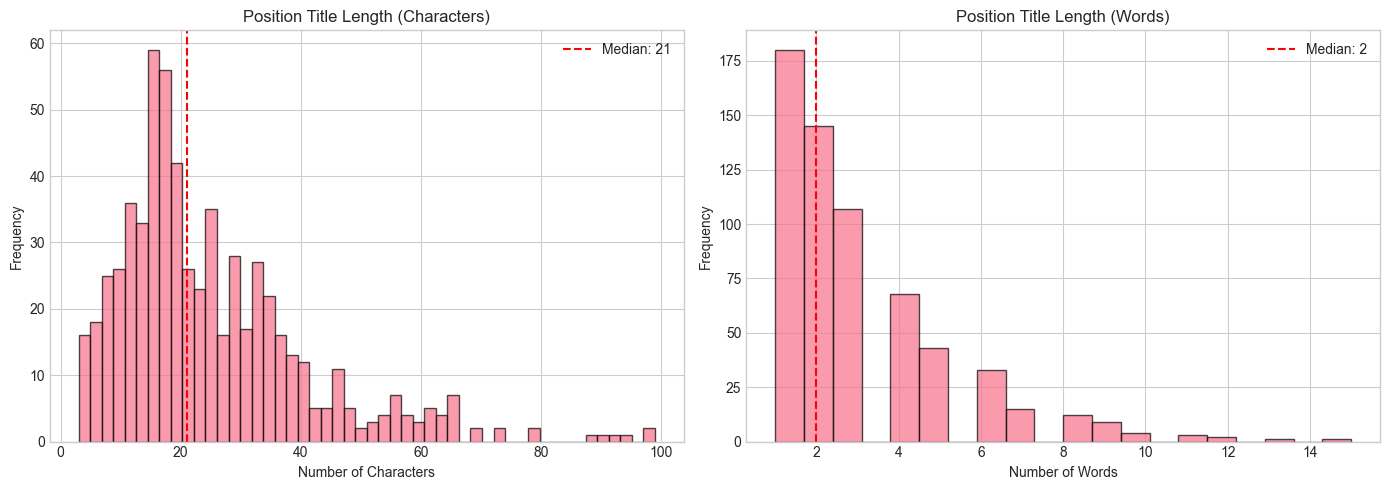

In [18]:
# Visualize title length distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Character length
axes[0].hist(df_active['title_length'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Position Title Length (Characters)', fontsize=12)
axes[0].set_xlabel('Number of Characters')
axes[0].set_ylabel('Frequency')
axes[0].axvline(df_active['title_length'].median(), color='red', linestyle='--', label=f"Median: {df_active['title_length'].median():.0f}")
axes[0].legend()

# Word count
axes[1].hist(df_active['title_word_count'], bins=20, edgecolor='black', alpha=0.7)
axes[1].set_title('Position Title Length (Words)', fontsize=12)
axes[1].set_xlabel('Number of Words')
axes[1].set_ylabel('Frequency')
axes[1].axvline(df_active['title_word_count'].median(), color='red', linestyle='--', label=f"Median: {df_active['title_word_count'].median():.0f}")
axes[1].legend()

plt.tight_layout()
plt.savefig('../reports/figures/title_length_distribution.png', dpi=150)
plt.show()

In [19]:
# Sample position titles by department
print("Sample Position Titles by Department:\n")
for dept in df_active['department'].unique()[:8]:  # First 8 departments
    print(f"=== {dept} ===")
    samples = df_active[df_active['department'] == dept]['position'].head(5).tolist()
    for s in samples:
        print(f"  - {s}")
    print()

Sample Position Titles by Department:

=== Other ===
  - Prokurist
  - CFO
  - Betriebswirtin
  - Prokuristin
  - CFO

=== Information Technology ===
  - Solutions Architect
  - Principal RF Design Engineer
  - IT Systems and Network Engineer
  - IT-Teamleiter
  - Senior IT-Sicherheitsbeauftragter

=== Consulting ===
  - Medizintechnik Beratung
  - energy and sustainability consultant bei
  - Human Resources Consultant
  - Practice Leader, Data Valorization Strategy
  - Danışmanlık

=== Business Development ===
  - Director expansión de negocio.
  - Business Development Manager
  - New Business Manager
  - Strategic Engagement Manager
  - Partner

=== Sales ===
  - Gerente comercial
  - Kaufmännischer Leiter
  - Director Sales
  - Chief Revenue Officer (CRO)
  - Inside Sales

=== Administrative ===
  - Administrador Unico
  - APL-ansvarig, samordning
  - Büroleiter | Pressesprecher
  - Verwaltungsangestellter
  - Büroleiter

=== Human Resources ===
  - Human Resources Generalist
  - He

## 8. Language Detection (Multilingual Data)

In [20]:
# Simple language detection based on common words
def detect_language_simple(text):
    """Simple heuristic-based language detection."""
    text_lower = text.lower()
    
    # German indicators
    german_words = ['und', 'der', 'die', 'für', 'bei', 'leiter', 'berater', 'mitarbeiter', 'geschäftsführer']
    # French indicators
    french_words = ['de', 'du', 'la', 'le', 'responsable', 'directeur', 'chargé', 'chef']
    # Spanish indicators
    spanish_words = ['de', 'del', 'director', 'gerente', 'jefe']
    
    german_score = sum(1 for w in german_words if w in text_lower)
    french_score = sum(1 for w in french_words if w in text_lower)
    
    if german_score > french_score and german_score > 0:
        return 'German'
    elif french_score > german_score and french_score > 0:
        return 'French'
    else:
        return 'English/Other'

df_active['detected_language'] = df_active['position'].apply(detect_language_simple)

print("Detected Languages:")
print(df_active['detected_language'].value_counts())

Detected Languages:
detected_language
English/Other    417
French           145
German            61
Name: count, dtype: int64


In [21]:
# Sample titles by detected language
for lang in df_active['detected_language'].unique():
    print(f"\n=== {lang} Examples ===")
    samples = df_active[df_active['detected_language'] == lang]['position'].sample(min(5, len(df_active[df_active['detected_language'] == lang]))).tolist()
    for s in samples:
        print(f"  - {s}")


=== English/Other Examples ===
  - Regionalbeauftragter Club Sachsen, Thüringen, Sachsen-Anhalt Süd
  - Geschäftsführender Gesellschafter
  - CEO
  - Projektleiter Bestandesentwicklung bei Liegenschaften Stadt Zürich
  - Programmierer

=== French Examples ===
  - Produktmanager Optomechanik
  - Key Account Director Europe, Middle East & Africa
  - Special Education Advocate/Education Consultant
  - Director expansión de negocio.
  - Algemeen directeur

=== German Examples ===
  - Partner und VRP
  - Einrichtungsberater
  - Founder
  - Geschäftsführer + Berater + Designer
  - Founder and owner


### Language Observations:
- The dataset is **multilingual** (English, German, French, Spanish, etc.)
- This is important for model design:
  - Rule-based matching needs multilingual patterns
  - Embeddings should use multilingual models

## 9. Label Dictionary Analysis

In [22]:
# Analyze department label dictionary
print("Department Label Dictionary:")
print(f"  Total examples: {len(department_labels)}")
print(f"  Unique labels: {department_labels['label'].nunique()}")
print("\n  Labels and counts:")
print(department_labels['label'].value_counts())

Department Label Dictionary:
  Total examples: 10145
  Unique labels: 11

  Labels and counts:
label
Marketing                 4295
Sales                     3328
Information Technology    1305
Business Development       620
Project Management         201
Consulting                 167
Administrative              83
Other                       42
Purchasing                  40
Customer Support            33
Human Resources             31
Name: count, dtype: int64


In [23]:
# Analyze seniority label dictionary
print("Seniority Label Dictionary:")
print(f"  Total examples: {len(seniority_labels)}")
print(f"  Unique labels: {seniority_labels['label'].nunique()}")
print("\n  Labels and counts:")
print(seniority_labels['label'].value_counts())

Seniority Label Dictionary:
  Total examples: 9428
  Unique labels: 5

  Labels and counts:
label
Senior        3733
Lead          3546
Director       984
Management     756
Junior         409
Name: count, dtype: int64


In [24]:
# Sample text -> label mappings
print("Sample Department Mappings:")
department_labels.sample(10)

Sample Department Mappings:


,text,label
8648,Marketing Communications Manager Europe & Nort...,Marketing
6952,Leiter Vertrieb Innendienst,Sales
5346,Operativer Projektleiter CRM,Information Technology
4514,Head of Business Development Workflow Automation,Business Development
4296,Sales Director Compliance Solutions,Sales
4077,Director International Sales ECNE,Sales
5885,Leiterin Telemarketing,Marketing
3144,Salesforce Technical Leader,Sales
7507,Business Development and Marketing Executive,Marketing
9751,Salesforce CRM Business Process Manager,Sales


In [25]:
print("Sample Seniority Mappings:")
seniority_labels.sample(10)

Sample Seniority Mappings:


,text,label
6445,EU Event Manager,Senior
3961,Vertriebsleiter Frontoffice,Lead
8973,Sales Manager Retail Lighting,Senior
6554,Manager Data Center Solution,Senior
2870,Head of PR & Communications,Lead
7873,Marketing and Event Management Assistant,Senior
6792,Senior Projektmanager,Senior
1494,Director International Business Development,Director
5643,Leitung Vertrieb und Key Account Management,Lead
1908,Director Key Account Sales,Director


## 10. Career History Patterns (Extensions)

Positions per CV:
count    609.000000
mean       4.331691
std        3.561259
min        1.000000
25%        1.000000
50%        4.000000
75%        6.000000
max       37.000000
dtype: float64


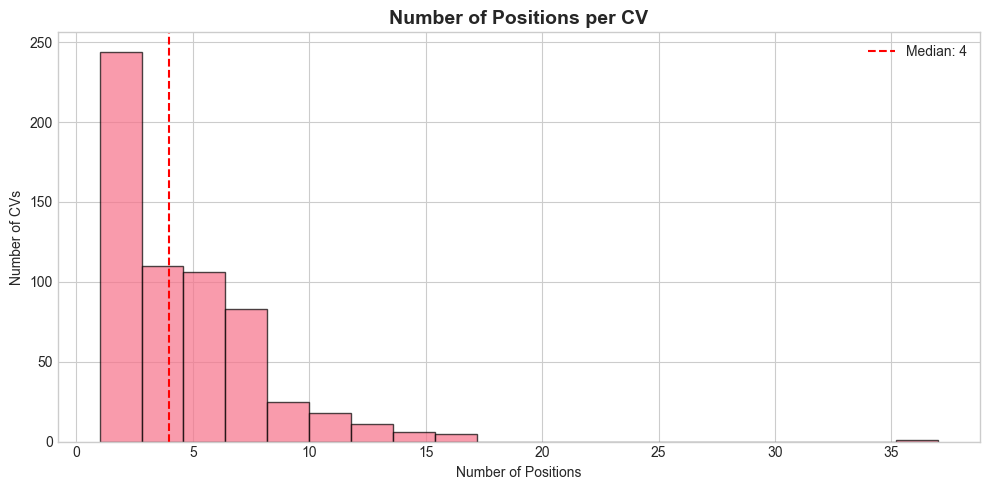

In [26]:
# Positions per CV
positions_per_cv = df_annotated.groupby('cv_id').size()

print("Positions per CV:")
print(positions_per_cv.describe())

fig, ax = plt.subplots(figsize=(10, 5))
positions_per_cv.hist(bins=20, ax=ax, edgecolor='black', alpha=0.7)
ax.set_title('Number of Positions per CV', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of Positions')
ax.set_ylabel('Number of CVs')
ax.axvline(positions_per_cv.median(), color='red', linestyle='--', label=f"Median: {positions_per_cv.median():.0f}")
ax.legend()
plt.tight_layout()
plt.savefig('../reports/figures/positions_per_cv.png', dpi=150)
plt.show()

In [27]:
# Department consistency within CVs
def get_cv_department_consistency(cv_id):
    cv_depts = df_annotated[df_annotated['cv_id'] == cv_id]['department'].unique()
    return len(cv_depts) == 1

cv_ids = df_annotated['cv_id'].unique()
consistent_count = sum(get_cv_department_consistency(cid) for cid in cv_ids)

print(f"CVs with consistent department across all positions: {consistent_count}/{len(cv_ids)} ({consistent_count/len(cv_ids):.1%})")

CVs with consistent department across all positions: 288/609 (47.3%)


## 11. Summary Statistics

In [28]:
# Create summary table
summary = {
    'Metric': [
        'Total CVs (annotated)',
        'Total CVs (unannotated)',
        'Total positions (annotated)',
        'Active positions (our training set)',
        'Avg positions per CV',
        'Unique departments',
        'Unique seniority levels',
        'Department label examples',
        'Seniority label examples',
        'Avg title length (chars)',
        'Avg title length (words)',
    ],
    'Value': [
        len(cvs_annotated),
        len(cvs_not_annotated),
        len(df_annotated),
        len(df_active),
        f"{positions_per_cv.mean():.1f}",
        df_active['department'].nunique(),
        df_active['seniority'].nunique(),
        len(department_labels),
        len(seniority_labels),
        f"{df_active['title_length'].mean():.1f}",
        f"{df_active['title_word_count'].mean():.1f}",
    ]
}

summary_df = pd.DataFrame(summary)
print(summary_df.to_string(index=False))

                             Metric Value
              Total CVs (annotated)   609
            Total CVs (unannotated)   390
        Total positions (annotated)  2638
Active positions (our training set)   623
               Avg positions per CV   4.3
                 Unique departments    11
            Unique seniority levels     6
          Department label examples 10145
           Seniority label examples  9428
           Avg title length (chars)  25.0
           Avg title length (words)   3.0


## 12. Key Findings & Implications for Modeling

### Data Characteristics:
1. **Multilingual data**: Position titles in English, German, French, Spanish → Need multilingual embeddings
2. **Class imbalance**: "Other" dominates departments → May need class weighting or resampling
3. **Short text**: Most titles are 2-5 words → Limited context for models
4. **Multiple active positions**: Some people have multiple current jobs → Handle carefully

### Modeling Implications:
1. **Rule-based**: Can leverage label dictionaries directly for exact/fuzzy matching
2. **Embedding-based**: Use multilingual models like `paraphrase-multilingual-MiniLM-L12-v2`
3. **Supervised**: Enough labeled examples for fine-tuning, but watch for class imbalance
4. **Extensions**: Career history can inform seniority (more positions = more experience)

### Next Steps:
1. Implement baseline rule-based classifier using exact matching
2. Test embedding similarity with label descriptions
3. Train TF-IDF + LogReg as supervised baseline
4. Compare approaches on held-out test set

In [29]:
# Save active positions for modeling
df_active.to_csv(DATA_DIR / 'active_positions_processed.csv', index=False)
print(f"Saved {len(df_active)} active positions to 'active_positions_processed.csv'")

Saved 623 active positions to 'active_positions_processed.csv'
